JeDI coverage: 1871-07 → 2011-09
Merged coverage: 1871-07 → 2011-09
  year_month  jellyfish_records  sst_c  temp_anomaly_c
0    1871-07                  1    0.0       -0.285759
1    1871-09                  1    0.0       -0.514587
2    1872-08                  1    0.0       -0.274426
3    1872-09                  1    0.0       -0.421569
4    1873-04                  3    0.0       -0.864583

Correlation matrix:
                    jellyfish_records  sst_c  temp_anomaly_c
jellyfish_records           1.000000    NaN        0.235801
sst_c                            NaN    NaN             NaN
temp_anomaly_c              0.235801    NaN        1.000000


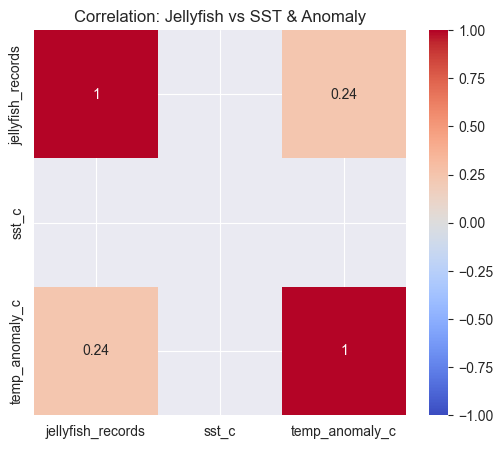

[SKIP] Not enough variation for Jellyfish vs SST


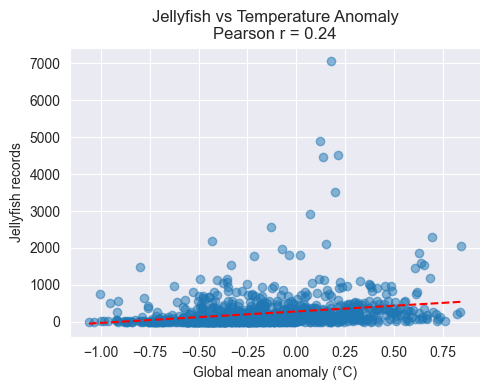

In [14]:
# %% Jellyfish × SST/Anomaly correlation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

# ---------------------------
# 1) Load and clean JeDI jellyfish data
# ---------------------------
jedi = pd.read_csv("data/JeDI.csv", low_memory=False).replace("nd", pd.NA)
jedi.columns = jedi.columns.str.strip().str.lower()

# Rename columns flexibly
rename_map = {
    "lat": "lat", "latitude": "lat",
    "lon": "lon", "longitude": "lon",
    "year": "year", "yr": "year",
    "month": "month", "mon": "month",
    "day": "day"
}
jedi = jedi.rename(columns={k: v for k, v in rename_map.items() if k in jedi.columns})

# Convert numerics
for col in ["year","month","day","lat","lon"]:
    if col in jedi.columns:
        jedi[col] = pd.to_numeric(jedi[col], errors="coerce")

# Keep only "present" records
if "presence_absence" in jedi.columns:
    jedi = jedi[jedi["presence_absence"].astype(str).str.lower().eq("present")]

# Fill missing time info
if "day" not in jedi.columns:
    jedi["day"] = 1
if "month" not in jedi.columns:
    jedi["month"] = 1

# Build datetime
jedi["time"] = pd.to_datetime(
    dict(year=jedi["year"], month=jedi["month"], day=jedi["day"]),
    errors="coerce"
)
jedi = jedi.dropna(subset=["time"]).copy()
jedi["year_month"] = jedi["time"].dt.to_period("M")

# Aggregate by month
jelly_monthly = (
    jedi.groupby("year_month")
    .size()
    .rename("jellyfish_records")
    .reset_index()
)
jelly_monthly["time"] = jelly_monthly["year_month"].dt.to_timestamp()

print("JeDI coverage:", jelly_monthly["year_month"].min(), "→", jelly_monthly["year_month"].max())

# ---------------------------
# 2) Load NOAA SST & anomalies
# ---------------------------
url_sst = "https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"
url_anom = "https://www.ncei.noaa.gov/thredds/dodsC/noaa-global-temp-v6/NOAAGlobalTemp_v6.0.0_gridded_s185001_e202508_c20250909T092005.nc"

ds_sst = xr.open_dataset(url_sst)
ds_anom = xr.open_dataset(url_anom)

# Restrict to years overlapping with JeDI (e.g., 1950–2010 for stability)
time_min = str(jelly_monthly["time"].min().year)
time_max = str(jelly_monthly["time"].max().year)

# Global mean SST (absolute °C)
sst_global = (
    ds_sst["sst"]
    .sel(time=slice(time_min, time_max))
    .where(ds_sst["sst"] > -1e3)   # mask missing
    .mean(dim=["lat","lon"])
    .to_dataframe()
    .reset_index()
    .rename(columns={"sst":"sst_c"})
)
sst_global["year_month"] = sst_global["time"].dt.to_period("M")

# Global mean anomalies (relative °C)
anom_global = (
    ds_anom["anom"]
    .isel(z=0)   # surface layer
    .sel(time=slice(time_min, time_max))
    .mean(dim=["lat","lon"])
    .to_dataframe()
    .reset_index()
    .rename(columns={"anom":"temp_anomaly_c"})
)
anom_global["year_month"] = anom_global["time"].dt.to_period("M")

# Merge climate datasets
climate = pd.merge(
    sst_global[["year_month","sst_c"]],
    anom_global[["year_month","temp_anomaly_c"]],
    on="year_month", how="inner"
)

# ---------------------------
# 3) Merge biology × climate
# ---------------------------
data = pd.merge(
    jelly_monthly[["year_month","jellyfish_records"]],
    climate, on="year_month", how="inner"
).sort_values("year_month")

print("Merged coverage:", data["year_month"].min(), "→", data["year_month"].max())
print(data.head())

# ---------------------------
# 4) Correlation
# ---------------------------
corr = data[["jellyfish_records","sst_c","temp_anomaly_c"]].corr()
print("\nCorrelation matrix:\n", corr)

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation: Jellyfish vs SST & Anomaly")
plt.show()

# ---------------------------
# 5) Scatter plots
# ---------------------------
def scatter_with_fit(x, y, xlabel, ylabel, title):
    mask = ~(x.isna() | y.isna() | np.isinf(x) | np.isinf(y))
    x = x[mask].astype(float).to_numpy()
    y = y[mask].astype(float).to_numpy()

    if len(x) < 20 or np.nanstd(x) == 0:
        print(f"[SKIP] Not enough variation for {title}")
        return

    m, b = np.polyfit(x, y, 1)
    xp = np.linspace(x.min(), x.max(), 100)
    yp = m*xp + b

    plt.figure(figsize=(5,4))
    plt.scatter(x, y, alpha=0.5)
    plt.plot(xp, yp, "--", color="red")
    r = np.corrcoef(x,y)[0,1]
    plt.title(f"{title}\nPearson r = {r:.2f}")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

scatter_with_fit(data["sst_c"], data["jellyfish_records"],
                 "Global mean SST (°C)", "Jellyfish records",
                 "Jellyfish vs SST")

scatter_with_fit(data["temp_anomaly_c"], data["jellyfish_records"],
                 "Global mean anomaly (°C)", "Jellyfish records",
                 "Jellyfish vs Temperature Anomaly")


JeDI coverage: 1790-01 → 2011-09
SST coverage: 1854-01 → 2025-08
Merged coverage: 1871-01 → 2011-09
Number of merged months: 1073

Correlation matrix:
                    jellyfish_records  sst
jellyfish_records                1.0  NaN
sst                              NaN  NaN


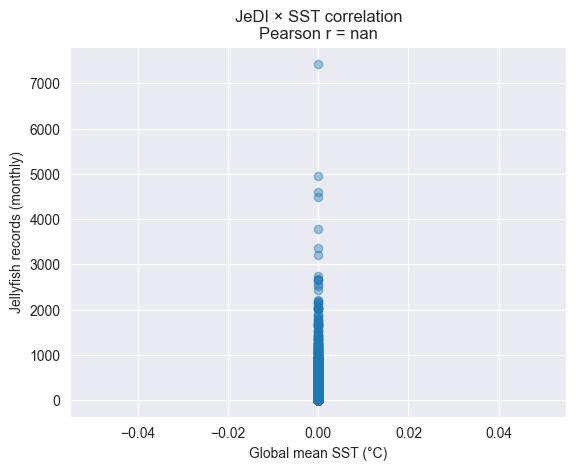

In [21]:
# %% Correlation JeDI × SST (monthly, 1854–2011)
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# --- 1. Jellyfish (JeDI)
jedi = pd.read_csv("data/JeDI.csv", low_memory=False)
jedi = jedi.replace("nd", pd.NA)
jedi.columns = jedi.columns.str.strip().str.lower()

# Build datetime
for col in ["year","month","day"]:
    if col in jedi.columns:
        jedi[col] = pd.to_numeric(jedi[col], errors="coerce")

if "month" in jedi.columns:
    jedi["month"] = jedi["month"].fillna(1).astype(int)
if "day" in jedi.columns:
    jedi["day"] = jedi["day"].fillna(1).astype(int)

jedi["time"] = pd.to_datetime(
    dict(year=jedi["year"], month=jedi["month"], day=jedi["day"]),
    errors="coerce"
)
jedi = jedi.dropna(subset=["time"]).copy()
jedi["year_month"] = jedi["time"].dt.to_period("M")

# Monthly counts
jelly_monthly = (
    jedi.groupby("year_month")
    .size()
    .reset_index(name="jellyfish_records")
)

print("JeDI coverage:", jelly_monthly["year_month"].min(), "→", jelly_monthly["year_month"].max())

# --- 2. NOAA SST (ERSSTv5 global monthly mean)
url_sst = "https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"
ds_sst = xr.open_dataset(url_sst)

# Replace fill values
sst = ds_sst["sst"].where(ds_sst["sst"] > -9e20)

# Global monthly mean
sst_global = (
    sst.mean(dim=["lat","lon"], skipna=True)
    .to_dataframe()
    .reset_index()
    .rename(columns={"sst":"sst"})
)
sst_global["year_month"] = sst_global["time"].dt.to_period("M")

print("SST coverage:", sst_global["year_month"].min(), "→", sst_global["year_month"].max())

# --- 3. Merge on common timeframe
df = pd.merge(jelly_monthly, sst_global, on="year_month", how="inner")
df = df.dropna(subset=["jellyfish_records","sst"])

print("Merged coverage:", df["year_month"].min(), "→", df["year_month"].max())
print("Number of merged months:", len(df))

# --- 4. Correlation
corr = df[["jellyfish_records","sst"]].corr()
print("\nCorrelation matrix:\n", corr)

# --- 5. Scatter plot
plt.scatter(df["sst"], df["jellyfish_records"], alpha=0.4)
plt.xlabel("Global mean SST (°C)")
plt.ylabel("Jellyfish records (monthly)")
plt.title(f"JeDI × SST correlation\nPearson r = {corr.iloc[0,1]:.2f}")
plt.show()
